<a href="https://colab.research.google.com/github/FireDragon00/LaTeX-Template-Cn/blob/master/5_4%E6%95%B4%E5%9B%BE%E5%88%86%E7%B1%BB_%E6%94%B9GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dgl
!pip install torch

     |████████████████████████████████| 4.4 MB 3.8 MB/s 


**创建一个神经网络**

In [3]:
import dgl
import torch
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.nn.pytorch.conv import GATConv
from dgl.nn.pytorch.conv import DenseGraphConv
from dgl.nn.pytorch.glob import SortPooling


class Classifier(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Classifier, self).__init__()
    self.gat1 = GATConv(in_dim, hidden_dim, 5)
    self.gat2 = GATConv(hidden_dim*5, hidden_dim, 5)
    
    #l2_out: torch.Size([3371, 5, 20])==>l2_flatten: torch.Size([3371, 100])
    self.sortpooling = SortPooling(k=16)
    #sortpool: torch.Size([188, 1600])
    self.conv1D_1 = nn.Conv1d(1, 128, kernel_size=3)
    self.maxpooling = nn.MaxPool1d(3)
    self.conv1D_2 = nn.Conv1d(128, 256, kernel_size=2)
    # self.dense2 = DenseGraphConv(512, 512, norm=True)
    self.classify = nn.Linear(256*531, n_classes)

  def forward(self, g, h):
    # print('raw_shape:',h.size())
    # 应用图卷积和激活函数
    h = F.relu(self.gat1(g, h))
    # print('l1_out:', h.size())
    h = h.flatten(1)
    # print('l1_flatten:', h.size())
    h = F.relu(self.gat2(g, h))
    # print('l2_out:', h.size())
    h = h.flatten(1)
    # print('l2_flatten:', h.size())
    h = self.sortpooling(g, h)
    # print('pool1:', h.size())
    h = h.view(188, 1, 1600)
    # print('view:', h.size())
    h = self.conv1D_1(h)
    # print('conv1:', h.size())
    h = self.maxpooling(h)
    # print('pool2:', h.size())
    h = self.conv1D_2(h)
    # print('conv2:', h.size())
    h = F.relu(h.flatten(1))
    h = F.dropout(h)
    with g.local_scope():
        return self.classify(h)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


**下载数据集**

In [4]:
import dgl.data
dataset = dgl.data.GINDataset('MUTAG', False)

Extracting file to /root/.dgl/GINDataset


In [5]:
print(dataset[0])

(Graph(num_nodes=23, num_edges=54,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


**批处理，加快训练速度**

In [6]:
from dgl.dataloading import GraphDataLoader
dataloader = GraphDataLoader(
  dataset,
  batch_size=1024,
  drop_last=False,
  shuffle=True)


**训练神经网络**

In [10]:
import torch.nn.functional as F

# 这仅是个例子，特征尺寸是7
model = Classifier(7, 20, 5)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(50):
  epoch_loss = 0
  i = 0
  for batched_graph, labels in dataloader:
      # print(labels)
      feats = batched_graph.ndata['attr']
      logits = model(batched_graph, feats)
      # print(logits.size())
      loss = F.cross_entropy(logits, labels)
      opt.zero_grad()
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()
      i += 1
  epoch_loss /= (i+1)
  print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
  epoch_losses.append(epoch_loss)


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 0, loss 0.8202
Epoch 1, loss 0.3373
Epoch 2, loss 2.2525
Epoch 3, loss 1.0784
Epoch 4, loss 0.6138
Epoch 5, loss 0.5039
Epoch 6, loss 0.3044
Epoch 7, loss 0.3393
Epoch 8, loss 0.3451
Epoch 9, loss 0.3265
Epoch 10, loss 0.3188
Epoch 11, loss 0.3399
Epoch 12, loss 0.3424
Epoch 13, loss 0.3244
Epoch 14, loss 0.3139
Epoch 15, loss 0.3082
Epoch 16, loss 0.2993
Epoch 17, loss 0.2931
Epoch 18, loss 0.2861
Epoch 19, loss 0.2827
Epoch 20, loss 0.2692
Epoch 21, loss 0.2602
Epoch 22, loss 0.2482
Epoch 23, loss 0.2459
Epoch 24, loss 0.2256
Epoch 25, loss 0.2324
Epoch 26, loss 0.2175
Epoch 27, loss 0.2071
Epoch 28, loss 0.2074
Epoch 29, loss 0.1911
Epoch 30, loss 0.1981
Epoch 31, loss 0.1986
Epoch 32, loss 0.2001
Epoch 33, loss 0.2109
Epoch 34, loss 0.1973
Epoch 35, loss 0.2019
Epoch 36, loss 0.2028
Epoch 37, loss 0.2099
Epoch 38, loss 0.2024
Epoch 39, loss 0.1931
Epoch 40, loss 0.2023
Epoch 41, loss 0.1930
Epoch 42, loss 0.1943
Epoch 43, loss 0.1973
Epoch 44, loss 0.1870
Epoch 45, loss 0.196

In [8]:
!pip install matplotlib

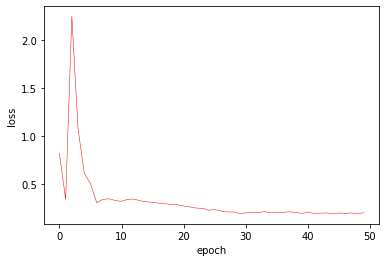

In [20]:
import matplotlib.pyplot as plt


plt.xlabel("epoch")
plt.ylabel("loss")
x = list(range(len(epoch_losses)))
# print(x)
plt.plot(x,epoch_losses,linewidth=0.5,c='red')
plt.show()

In [17]:
# Test the model
model.eval()  # eval mode(batch norm uses moving mean/variance 
              #instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for batched_graph, labels in dataloader:
        feats = batched_graph.ndata['attr']
        outputs = model(batched_graph, feats)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test accuracy of the model on the 10000 test batched_graph: {} %'
          .format(100 * correct / total))

Test accuracy of the model on the 10000 test batched_graph: 85.1063829787234 %
